In [ ]:
"""
    Project Name: PdM Model for NASA Jet Engines
    Author: Arpi Derm
    Description: This model aims to use PdM model and RUL to predict failures in point time T in near future.
                 This specific model is built and trained for the NASA's PCoE Turbofan Engine Degradation (Run-To-Failure) dataset.
    Dataset Description: 
                Dataset description along with its variable can be found in the dataset paper writtent by 
                Manuel Arias Chao,Chetan Kulkarni, Kai Goebel and Olga Fink. https://dx.doi.org/10.3390/data6010005
    Variable Name Descriptions:
    
"""

import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from pandas import DataFrame
from matplotlib import gridspec
from google.colab import drive

drive.mount("/content/drive")

# Load all datasets
DS_001 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS01-005.h5"
DS_002 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS02-006.h5"
DS_003 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS03-012.h5"
DS_004 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS04.h5"
DS_005 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS05.h5"
DS_006 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS06.h5"
DS_007 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS07.h5"
DS_008 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08a-009.h5"
DS_009 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08c-008.h5"
DS_010 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08d-010.h5"

Mounted at /content/drive


In [21]:
class EngineRUL:
    def __init__(self):
        print("Engine RUL Predictor.")

    def load_hdf5_to_numpy_arr(self, file_name_hdf5):
        """
        Convert HDF5 raw data to numpy array.
        The data set is already broken to development and test sets. We just need to create separate variable sets for each.
        The dev set will be used for training the model and the test set will be used for evaluating and predictions.
        """

        op_time = time.process_time()

        with h5py.File(file_name_hdf5, "r") as hdf:

            # Get the model development set
            self.w_dev = np.array(hdf.get("W_dev"))  # Scenario-descriptor operating conditions (inputs to system model)
            self.x_s_dev = np.array(
                hdf.get("X_s_dev")
            )  # Estimates of measured physical properties (sensor measurements)
            self.x_v_dev = np.array(hdf.get("X_v_dev"))  # Unobserved measrued properties (Virtual sensors)
            self.t_dev = np.array(hdf.get("T_dev"))  # Engine heath parameters (inputs to system model)
            self.y_rul_dev = np.array(hdf.get("Y_dev"))  # Target output Y - RUL (Remainin Useful Life) of engine unit
            self.aux_dev = np.array(hdf.get("A_dev"))  # Auxiliary data

            # Get the model test set
            self.w_test = np.array(
                hdf.get("W_dev")
            )  # Scenario-descriptor operating conditions (inputs to system model)
            self.x_s_test = np.array(
                hdf.get("X_s_dev")
            )  # Estimates of measured physical properties (sensor measurements)
            self.x_v_test = np.array(hdf.get("X_v_dev"))  # Unobserved measrued properties (Virtual sensors)
            self.t_test = np.array(hdf.get("T_dev"))  # Engine heath parameters (inputs to system model)
            self.y_rul_test = np.array(hdf.get("Y_dev"))  # Target output Y - RUL (Remainin Useful Life) of engine unit
            self.aux_test = np.array(hdf.get("A_dev"))  # Auxiliary data

            # Get the variable names for each type of variable in the dataset
            self.w_var_names = np.array(hdf.get("W_var"))
            self.x_s_var_names = np.array(hdf.get("X_s_var"))
            self.x_v_var_names = np.array(hdf.get("X_v_var"))
            self.t_var_names = np.array(hdf.get("T_var"))
            self.a_var_names = np.array(hdf.get("A_var"))

            # from np.array to list dtype U4/U5
            self.w_var_names = list(np.array(self.w_var_names, dtype="U20"))
            self.x_s_var_names = list(np.array(self.x_s_var_names, dtype="U20"))
            self.x_v_var_names = list(np.array(self.x_v_var_names, dtype="U20"))
            self.t_var_names = list(np.array(self.t_var_names, dtype="U20"))
            self.a_var_names = list(np.array(self.a_var_names, dtype="U20"))

        # Create complete development and test set of each varaible type
        self.w = np.concatenate((self.w_dev, self.w_test), axis=0)
        self.x_s = np.concatenate((self.x_s_dev, self.x_s_test), axis=0)
        self.x_v = np.concatenate((self.x_v_dev, self.x_v_test), axis=0)
        self.t = np.concatenate((self.t_dev, self.t_test), axis=0)
        self.y_rul = np.concatenate((self.y_rul_dev, self.y_rul_test), axis=0)
        self.aux = np.concatenate((self.aux_dev, self.aux_test), axis=0)

        # Generate dataframes
        self.df_aux = DataFrame(data=self.aux, columns=self.a_var_names)
        self.df_T = DataFrame(data=T, columns=T_var) 
        self.df_T['unit'] = df_A['unit'].values
        self.df_T['cycle'] = df_A['cycle'].values
        self.df_Ts = df_T.drop_duplicates()
        self.df_Ts.describe()
        print("Operation time (sec): ", (time.process_time() - op_time))
    
    def get_dataset_info(self):

        # Engine units present in the loaded dataset
        print("Engine Units: " , np.unique(self.df_aux['unit']))

        # Plot Flight classes - according to the dataset document, there are three flight classes
        # Class 1 - Flight length (1-3) [h]
        # Class 2 - Flight length (3-5) [h]
        # Class 3 - Fligth length (5-7) [h]

        plt.plot(self.df_aux.unit, self.df_aux.Fc, 'o')
        plt.tick_params(axis='x', labelsize= 17 )
        plt.tick_params(axis='y', labelsize= 17 )
        plt.xlabel('Unit #', fontsize= 17)
        plt.ylabel('Flight Class #', fontsize= 17 )
        plt.show()

        # Engine Health Degradation Parameters



In [22]:
enginge_rul_predictor = EngineRUL()

Engine RUL Predictor.


In [24]:
enginge_rul_predictor.load_hdf5_to_numpy_arr(DS_001)

Operation time (sec):  5.237711580999999


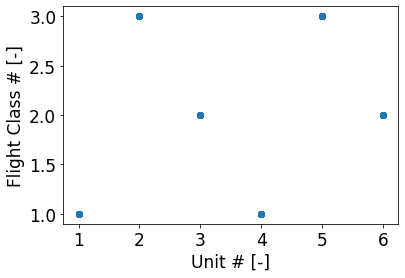

In [25]:
enginge_rul_predictor.get_dataset_info()